## Exercise 7.10 - Data Efficiency of n-Step Off-Policy Methods

Devise a small off-policy prediction problem and use it to show that the off-policy learning
algorithm using (7.13) and (7.2) is more data efficient than the simpler algorithm using
(7.1) and (7.9).

In [1]:
! pip3 -q install numpy matplotlib gym

In [2]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from td import td_off_policy_prediction

### Blackjack Value Estimation with Equal-Probable Random Policy

The benchmark is to estimate the value of a particular Blackjack card configuration when using
a target policy that always hits unless it has a score of 20 or higher. The behavioral policy
used to select actions is equal-probable random. Blackjack environment to run the benchmark in
si from OpenAI Gym and matches Example 5.1. 

The setup of the benchmark is exactly the same as Example 5.4. In this example, they
evaluated the state in which the dealer is showing a deuce, the sum of the player’s cards
is 13, and the player has a usable ace (that is, the player holds an ace and a deuce, or
equivalently three aces).

The environment and action selection are reset before each run to use the same random seed.
This makes the comparison noise-free and removes the need to average over many runs because
both algorithms are exposed exactly to the same sequence of states and actions. The goal is
to get estimate of the state value mentioned above in fewer episodes. In other words having
a higher data efficiency when learning from off-policy samples.

Reason why the more complex method based on (7.13) and (7.2) performs better is because it's
able to use data from episodes where target and behavioral policy disagree on the action
selection. Because the target policy is deterministic, there's frequently a point in the episode
when the behavioral policy selects an action that is impossible under the target policy because
it assigns 0 probability to it. 

After reaching this point of divergence one or more of the terms in the importance sampling
ratio $\rho_{t:h}$ become zero and this prevents any further learning from the episode data
in case of the simpler (7.9) and (7.1) method. More complex method one uses a value of the
state where the divergence happened as the target of the update and is able to utilize data
from the rest of the episode and learning from it.

Even though, it's not demonstrated here. Experimentation showed that the results hold across
a reasonable range of $n$-steps and learning rates $\alpha$.

In [3]:
class FixedResetWrapper(gym.ObservationWrapper):
    """ Always reset to same state and cast usable ace bool to int so
    the observation can be used for array indexing """

    def reset(self):
        self.env.dealer = [2]  # Deuce
        self.env.player = [1, 2]  # Ace and deuce
        return self.observation(self.env._get_obs())

    def observation(self, observation):
        return observation[0], observation[1], int(observation[2])


# Blackjack environment with a fixed reset
env = FixedResetWrapper(gym.make('Blackjack-v0'))

# Target value and target state per Example 5.4
v_star = -0.27726
state_star = env.reset()
assert state_star == (11 + 2, 2, 1)

In [4]:
# Target policy hits on 20 and 21 and sticks otherwise
target = np.zeros([32, 11, 2, 2], dtype=np.float)
target[:20, :, :, 0] = 1.0
target[20:, :, :, 1] = 1.0

# Behavior equal-probable random policy
behavior = np.zeros([32, 11, 2, 2], dtype=np.float)
behavior[:, :, :, 0:2] = 0.5

In [5]:
env.seed(19)
history0 = td_off_policy_prediction(env, target, behavior, n=3, num_episodes=100_000,
                                    alpha=1e-4, simpler=True)
env.seed(19)
history1 = td_off_policy_prediction(env, target, behavior, n=3, num_episodes=100_000,
                                    alpha=1e-4, simpler=False)

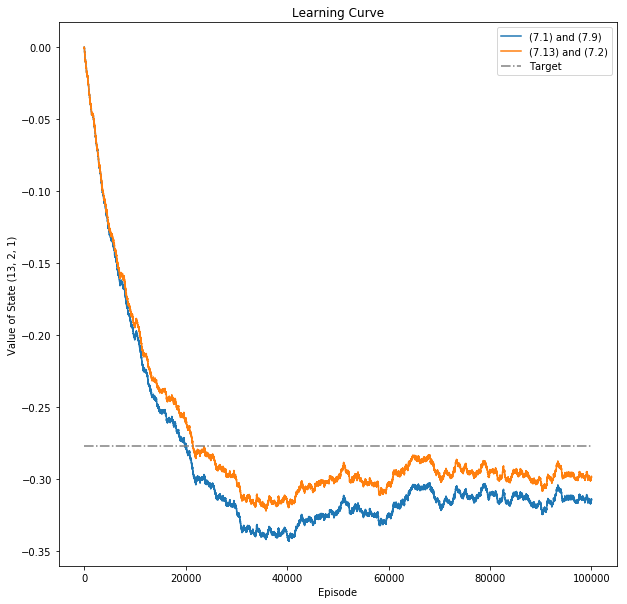

In [6]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel(f"Value of State {state_star}")
plt.plot([v[state_star] for v in history0], label='(7.1) and (7.9)')
plt.plot([v[state_star] for v in history1], label='(7.13) and (7.2)')
plt.plot([0, 100_000], [v_star, v_star], '-.', color='gray', label='Target')
plt.legend()
plt.show()